# MDRefinement

include automatic optimization of hyperparameters

In [1]:
import pandas
import os
import numpy as np
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
import sys
sys.path.append('../')

from MDRefine import load_data, minimizer, hyper_minimizer, MDRefinement

### Load data

just to show an example of how it works, take only 2 molecular systems (AAAA and CAAU, for instance) and exclude the unobserved NOEs, which are computationally more expensive

In [9]:
infos = {'global': {
    'path_directory': '../../DATA',
    'system_names': ['AAAA', 'CAAU', 'CCCC', 'GACC', 'UUUU', 'UCAAUC'],
    'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J', 'NOEs' , ('uNOEs', '<')],
    'forward_qs': ['backbone1_gamma', 'backbone2_beta_epsilon','sugar'],
    'obs': ['NOEs', 'uNOEs'],
    'forward_coeffs': 'original_fm_coeffs'}}

stride = 10

define the forward model (include also the possibility for selected_obs, namely, to compute only selected observables in cross validation)

In [10]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs=None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [11]:
infos['global']['forward_model'] = forward_model_fun

choose among force-field correction on $\alpha,\zeta$ or only on $\alpha$ dihedral angles 

In [12]:
infos['global']['names_ff_pars'] = ['sin alpha', 'cos alpha']

def ff_correction(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [13]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
loading  CAAU
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done


In [14]:
def forward_model_regularization(coeffs, coeffs_0):
    regularization = (
    3/8*(coeffs[0]-coeffs_0['A_gamma'])**2+1/2*(coeffs[1]-coeffs_0['B_gamma'])**2+(coeffs[2]-coeffs_0['C_gamma'])**2+(coeffs[0]-coeffs_0['A_gamma'])*(coeffs[2]-coeffs_0['C_gamma'])+
    3/8*(coeffs[3]-coeffs_0['A_beta'])**2+1/2*(coeffs[4]-coeffs_0['B_beta'])**2+(coeffs[5]-coeffs_0['C_beta'])**2+(coeffs[3]-coeffs_0['A_beta'])*(coeffs[5]-coeffs_0['C_beta'])+
    3/8*(coeffs[6]-coeffs_0['A_sugar'])**2+1/2*(coeffs[7]-coeffs_0['B_sugar'])**2+(coeffs[8]-coeffs_0['C_sugar'])**2+(coeffs[6]-coeffs_0['A_sugar'])*(coeffs[8]-coeffs_0['C_sugar']))

    return regularization

In [15]:
regularization = {'force_field_reg': 'KL divergence', 'forward_model_reg': forward_model_regularization}

### Case 1: ensemble + forward-model refinement

#### a. search for optimal hyperparameters

- select starting values for the hyperparameters (infty if no refinement in that direction);
- select also how to optimize the hyperparameters, namely, if you want to minimize the chi2 on which_set = 'validation' (new frames) or 'test' (new observables); 'validation' by default;
- select random_states, namely, how many splitting in cross validation.

In [10]:
starting_alpha = 1  # 10**2
starting_beta = np.inf
starting_gamma = 1  # np.inf

which_set = 'test'
random_states = 2

In [11]:
hyper_out = hyper_minimizer(data, regularization=regularization, starting_alpha=starting_alpha,
    starting_beta=starting_beta, starting_gamma=starting_gamma, random_states=random_states,
    which_set=which_set, ftol=1e-3)

Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('alpha', 0.0), ('gamma', 0.0)]
av. chi2:  77.01118223617408
av. gradient:  [-17.23856041   9.97427332]

log10 hyperpars:  [('alpha', 0.865555708393297), ('gamma', -0.5008126552592073)]
av. chi2:  47.70188683201872
av. gradient:  [-40.52578906  -5.7194981 ]

log10 hyperpars:  [('alpha', 4.3277785419664845), ('gamma', -2.504063276296036)]
av. chi2:  25.11921958650895
av. gradient:  [ 0.00739529 -0.39525074]


In [12]:
hyper_out

          fun: DeviceArray(25.11921959, dtype=float64)
     hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
 intermediate: <MDRefine.Functions.hyper_minimizer.<locals>.hyper_intermediate_class object at 0x7f18e9262ba8>
          jac: array([ 0.00739529, -0.39525074])
      message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
         nfev: 3
          nit: 1
         njev: 3
       status: 0
      success: True
            x: array([ 4.32777854, -2.50406328])

In [13]:
opt_alpha, opt_gamma = 10**hyper_out.x
opt_beta = np.inf  # since no force-field refinement

print(opt_alpha, opt_gamma)

21270.541292595375 0.0031328292407988133


#### b. search for optimal coefficients at optimized hyperparameters

In [14]:
Result = minimizer(data, regularization=regularization, alpha=opt_alpha, beta=opt_beta, gamma=opt_gamma)

New evaluation:
loss:  105.53099314111542
gradient:  [ 0.35668418  0.54328853  1.16395101 -2.33162811 -2.5788195  -2.45201969
  6.89197234 -4.87163109 11.66032094] 

New evaluation:
loss:  96.70787599131356
gradient:  [ 0.13111737  0.20816128  0.43701121 -1.30269304 -1.10038533  0.00485821
  0.95532742 -1.96797479  1.15977224] 

New evaluation:
loss:  99.6405581005918
gradient:  [-0.85281256 -1.25392735 -2.7341472   0.93042028  1.91534511  4.54906511
  1.77796713  4.94699882  2.94079273] 

New evaluation:
loss:  95.82627160775878
gradient:  [-0.18834124 -0.26654435 -0.59258401 -0.57765292 -0.12124657  1.4802517
  1.2222529   0.27750468  1.73777056] 

New evaluation:
loss:  95.13156936582754
gradient:  [ 0.17965491  0.27955597  0.59287329 -1.503536   -1.60948121 -1.37514625
  0.15303654  1.88669659  0.00901189] 

New evaluation:
loss:  93.98945140964484
gradient:  [ 0.25158121  0.38610819  0.82442886 -0.90755498 -0.88442218 -0.48836121
 -0.3948229   1.50695982 -0.82578724] 

New evaluat

In [18]:
vars(Result)

{'loss': DeviceArray(92.5849927, dtype=float64),
 'pars': array([10.05784402, -1.87897418, -0.23849716, 19.82552623, -4.57359976,
        -0.71990978,  8.69854279, -1.30798233, -0.57368674]),
 'mini':       fun: 92.58500045306377
  hess_inv: array([[ 2.58261327e+01, -2.27891508e+01,  3.32037176e+00,
          2.96942950e+01, -3.65826548e+01,  9.88567180e+00,
          8.72327923e-01,  1.83664566e-01, -2.65025585e-01],
        [-2.27891508e+01,  5.09418733e+01, -1.77043812e+01,
          4.70848561e+00, -2.52515139e+00, -9.96932630e-01,
         -1.56657105e+00, -2.15199428e-01,  5.10161533e-01],
        [ 3.32037176e+00, -1.77043812e+01,  7.65231597e+00,
         -1.10770601e+01,  1.20017204e+01, -2.40676001e+00,
          5.30890937e-01,  6.17438462e-02, -1.76700111e-01],
        [ 2.96942950e+01,  4.70848561e+00, -1.10770601e+01,
          7.19545796e+01, -8.20690460e+01,  1.94012373e+01,
          8.74799881e-02,  1.16258093e-01,  4.47002412e-02],
        [-3.65826548e+01, -2.525151

In [19]:
Result.D_KL_alpha

{'AAAA': DeviceArray(7.0999796e-06, dtype=float64),
 'CAAU': DeviceArray(5.73693733e-06, dtype=float64)}

In [20]:
vars(Result).keys()

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'reg_fm', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new'])

In [24]:
tot_chi2 = np.sum([item2 for item in Result.chi2.values() for item2 in item.values()])
print('1/2 chi2: ', 1/2*tot_chi2)

print('gamma*R: ', opt_gamma*Result.reg_fm)

tot_DKL = np.sum([l for l in Result.D_KL_alpha.values()])
print('alpha*D_KL: ', opt_alpha*tot_DKL)

loss = opt_gamma*Result.reg_fm + opt_alpha*tot_DKL + 1/2*tot_chi2
print('loss: ', loss)

1/2 chi2:  92.29550386025011
gamma*R:  0.01645336545456597
alpha*D_KL:  0.2730481716559569
loss:  92.58500539736063


In [30]:
if not np.isinf(opt_beta):
    temp = infos['global']['names_ff_pars']
    my_ff_coeffs = pandas.Series(Result.pars[:len(temp)], index=temp)
    print(my_ff_coeffs)

if not np.isinf(opt_gamma):
    fm_names = list(data['global'].forward_coeffs_0.keys())
    my_fm_coeffs = pandas.Series(Result.pars[-len(fm_names):], index=fm_names)
    print(my_fm_coeffs)

A_gamma    10.057844
B_gamma    -1.878974
C_gamma    -0.238497
A_beta     19.825526
B_beta     -4.573600
C_beta     -0.719910
A_sugar     8.698543
B_sugar    -1.307982
C_sugar    -0.573687
dtype: float64


#### c. plot refined forward model

In [ ]:
fm_coeffs_0 = pandas.read_csv('Results/original_fm_coeffs', index_col=0, header=None)[1]
fm_coeffs_Thorben = pandas.read_csv('Results/fm_coeffs_Thorben_ref', index_col=0, header=None)[1]

# hyperparameters derived by Thorben with chi2 and chi2 + R regularizations respectively
mini1_hyperpars = {'alpha': 85.3167852417281, 'beta': 0.019306977288832506*2}
mini2_hyperpars = {'alpha': 174.33288221999874, 'beta': 3.433320018281997*2} # those for fm_coeffs_Thorben

fm_coeffs = {}
fm_coeffs['original'] = fm_coeffs_0
fm_coeffs['Thorben'] = fm_coeffs_Thorben
fm_coeffs['mine'] = my_fm_coeffs

print(fm_coeffs)

{'original': 0
A_gamma     9.70
B_gamma    -1.80
C_gamma     0.00
A_beta     15.30
B_beta     -6.10
C_beta      1.60
A_sugar     9.67
B_sugar    -2.03
C_sugar     0.00
Name: 1, dtype: float64, 'Thorben': 0
A_gamma    10.07
B_gamma    -1.87
C_gamma    -0.13
A_beta     18.34
B_beta     -5.39
C_beta      0.11
A_sugar     7.81
B_sugar    -2.05
C_sugar     0.25
Name: 1, dtype: float64, 'mine': A_gamma    10.057844
B_gamma    -1.878974
C_gamma    -0.238497
A_beta     19.825526
B_beta     -4.573600
C_beta     -0.719910
A_sugar     8.698543
B_sugar    -1.307982
C_sugar    -0.573687
dtype: float64}


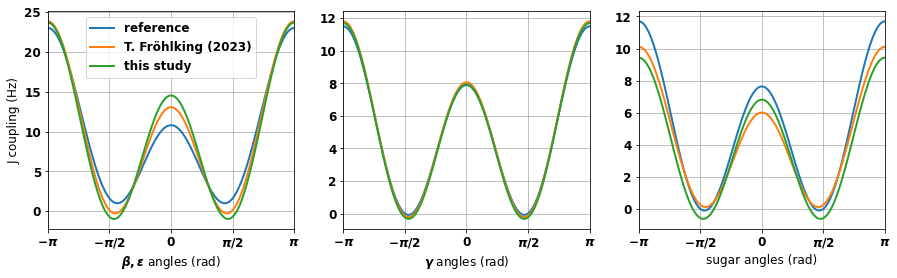

In [ ]:
font = {'weight' : 'bold', 'size' : 12}

# plt.rcdefaults()
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 10

fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(4)
fig.set_figwidth(15)

compute_deltaV = lambda fm_coeffs, angles, s: fm_coeffs['A_' + s]*np.cos(angles)**2 + fm_coeffs['B_' + s]*np.cos(angles) + fm_coeffs['C_' + s]*np.ones(len(angles))

# plt.suptitle(r'Refinement of Karplus equations $\alpha=%.2f,\beta=%.2f,\gamma=%.2f$' % (opt_alpha, opt_beta, opt_gamma))

angles = np.linspace(-np.pi, np.pi, 100)
titles = [r'$\beta,\epsilon$', r'$\gamma$', 'sugar']

for i,s in enumerate(['beta', 'gamma', 'sugar']):

    deltaV = {}

    deltaV = compute_deltaV(fm_coeffs['original'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='reference')

    deltaV = compute_deltaV(fm_coeffs['Thorben'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='T. Fröhlking (2023)')

    deltaV = compute_deltaV(fm_coeffs['mine'], angles, s) #  ['mean'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='this study') #   (average)')

    # deltaV = compute_deltaV(fm_coeffs['100 optimal'], angles, s) #  ['mean'], angles, s)
    # axs[i].plot(angles, deltaV, '-', label='this study 2') #   (average)')

    # for j in range(n_seeds):
    #     deltaV = compute_deltaV(fm_coeffs['mine'][j], angles, s)
    #     axs[i].plot(angles, deltaV, '-', color='tab:red')#, label='av. mine')


    # for k in ['original', 'mini2', 'mine']:
    #     deltaV[k] = fm_coeffs[k]['A_' + s]*np.cos(angles)**2 + fm_coeffs[k]['B_' + s]*np.cos(
    #         angles) + fm_coeffs[k]['C_' + s]*np.ones(len(angles))

    #     axs[i].plot(angles, deltaV[k], '-', label=k)
    
    axs[i].grid()
    axs[i].set_xlabel(titles[i] + ' angles (rad)')
    # axs[i].set_title(titles[i])
    axs[i].set_xlim([-np.pi, np.pi])
    axs[i].set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    axs[i].set_xticklabels([r'$-\pi$', r'$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

axs[0].legend()
axs[0].set_ylabel('J coupling (Hz)')

# plt.savefig('../Figures/Karplus_refinement_overall.png')
plt.show()

#### d. MDRefinement
you can do a. and b. at once with MDRefinement

In [145]:
result = MDRefinement(infos, stride=stride, regularization=regularization, starting_alpha=starting_alpha, starting_beta=starting_beta,
    starting_gamma=starting_gamma, random_states=random_states, which_set=which_set, ftol=1e-3, results_folder_name='my_results')

loading data from directory...
loading  AAAA
loading  CAAU
loading  CCCC
loading  GACC
loading  UUUU
loading  UCAAUC
done

search for optimal hyperparameters ...
Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('alpha', 0.0), ('gamma', 0.0)]
av. chi2:  1882.5293750250157
av. gradient:  [-6993.90734039   653.90645823]

log10 hyperpars:  [('alpha', 0.995657642965116), ('gamma', -0.09309059031475425)]
av. chi2:  221.64286461344193
av. gradient:  [-258.54466617   -0.43113097]

log10 hyperpars:  [('alpha', 1.0338905314985463), ('gamma', -0.0928911035706746)]
av. chi2:  213.31472476681185
av. gradient:  [-184.3861383     0.19624332]

log10 hyperpars:  [('alpha', 1.1289548243747463), ('gamma', -0.09329355453696532)]
av. chi2:  202.2402517826334
av. gradient:  [-65.89641972   1.20970637]

log10 hyperpars:  [('alpha', 1.181841603715893), ('gamma', -0.0949277633291624)]
av. chi2:  199.5830910323129
av

In [150]:
vars(result)

{'loss': DeviceArray(213.96887178, dtype=float64),
 'pars': array([10.16505107, -1.86078883, -0.1741575 , 19.24931188, -5.08950932,
        -0.33738188,  8.05111725, -1.76949318,  0.06056918]),
 'mini':       fun: 213.96887178273414
  hess_inv: array([[ 4.62592691e+00,  7.21946523e-01, -1.69167859e+00,
         -2.10601788e-01,  1.42175977e-02,  1.00679989e-01,
         -7.89530110e-01,  3.55870139e-01,  1.72517147e-01],
        [ 7.21946523e-01,  1.02368573e+00, -6.62989265e-01,
         -5.49474431e-02,  8.04738443e-03,  2.23069669e-02,
         -1.51671907e-01,  7.19948877e-02,  3.26037014e-02],
        [-1.69167859e+00, -6.62989265e-01,  8.56728279e-01,
          5.30350156e-02, -2.03440657e-03, -2.13563183e-02,
          2.83536969e-01, -1.19316743e-01, -7.87470554e-02],
        [-2.10601788e-01, -5.49474431e-02,  5.30350156e-02,
          1.58100230e+00, -5.56170916e-01, -3.47076202e-01,
          1.60343139e-01, -7.93383061e-02, -7.15729011e-03],
        [ 1.42175977e-02,  8.047

In [156]:
print(result.optimal_hyperpars)

opt_alpha = result.optimal_hyperpars['alpha']
opt_gamma = result.optimal_hyperpars['gamma']

opt_beta = np.inf

{'alpha': 49.54716895520075, 'gamma': 0.5602270422746097}


In [154]:
tot_chi2 = np.sum([item2 for item in result.chi2.values() for item2 in item.values()])
print('1/2 chi2: ', 1/2*tot_chi2)

print('gamma*R: ', opt_gamma*result.reg_fm)

tot_DKL = np.sum([l for l in result.D_KL_alpha.values()])
print('alpha*D_KL: ', opt_alpha*tot_DKL)

loss = opt_gamma*result.reg_fm + opt_alpha*tot_DKL + 1/2*tot_chi2
print('loss: ', loss)

1/2 chi2:  174.27007569044167
gamma*R:  1.9138452596645963
alpha*D_KL:  37.78557976629863
loss:  213.9695007164049


In [158]:
if not np.isinf(opt_beta):
    temp = infos['global']['names_ff_pars']
    my_ff_coeffs = pandas.Series(result.pars[:len(temp)], index=temp)
    print(my_ff_coeffs)

if not np.isinf(opt_gamma):
    fm_names = list(data._global_.forward_coeffs_0.keys())
    my_fm_coeffs = pandas.Series(result.pars[-len(fm_names):], index=fm_names)
    print(my_fm_coeffs)

A_gamma    10.165051
B_gamma    -1.860789
C_gamma    -0.174158
A_beta     19.249312
B_beta     -5.089509
C_beta     -0.337382
A_sugar     8.051117
B_sugar    -1.769493
C_sugar     0.060569
dtype: float64


### Case 2: fully combined

use directly MDRefinement

In [18]:
starting_alpha = 1
starting_beta = 1
starting_gamma = 1

which_set = 'test'
random_states = 2

In [19]:
result2 = MDRefinement(infos, stride=stride, regularization=regularization, starting_alpha=starting_alpha, starting_beta=starting_beta,
    starting_gamma=starting_gamma, random_states=random_states, which_set=which_set, results_folder_name='my_results')

loading data from directory...
loading  AAAA
done

search for optimal hyperparameters ...
Input random_state employed both for test_obs and test_frames
Input random_state employed both for test_obs and test_frames

log10 hyperpars:  [('alpha', 0.0), ('beta', 0.0), ('gamma', 0.0)]


In [29]:
vars(result2)

{'loss': DeviceArray(96.12251186, dtype=float64),
 'pars': array([ 2.76321235e-05, -2.18331185e-05,  9.83227997e+00, -1.87717363e+00,
        -1.46904972e-01,  1.77245979e+01, -5.39333109e+00,  5.31454709e-01,
         8.90114455e+00, -1.39504953e+00, -5.06898311e-01]),
 'mini':       fun: 96.1225118564539
  hess_inv: array([[ 8.23213717e-07, -4.99645239e-08,  2.93976019e-07,
          5.73383617e-08, -1.49175646e-07,  7.55314591e-07,
          2.81353482e-08, -2.52903585e-07, -1.11144890e-07,
          7.84302094e-08,  8.57138334e-08],
        [-4.99645239e-08,  4.54216894e-06, -2.73602005e-07,
          6.96543384e-07, -1.60554677e-07,  6.24752355e-07,
          6.24755310e-07, -3.00942732e-07,  1.64911458e-06,
         -1.11863696e-07, -1.11277073e-06],
        [ 2.93976019e-07, -2.73602005e-07,  2.97336519e+00,
          3.13368546e-01, -1.20972684e+00,  1.49555567e-02,
          1.29027712e-01,  1.06359251e-01, -2.50449105e-01,
         -6.92214213e-02,  2.14145023e-01],
        [

In [36]:
vars(result2).keys()

dict_keys(['loss', 'pars', 'mini', 'min_lambdas', 'minis', 'intermediates', 'time', 'weights_P', 'logZ_P', 'reg_ff', 'reg_fm', 'D_KL_alpha', 'abs_difference', 'av_g', 'chi2', 'logZ_new', 'weights_new', 'optimal_hyperpars', 'hyper_minimization'])

In [38]:
print(result2.optimal_hyperpars)

opt_alpha = result2.optimal_hyperpars['alpha']
opt_beta = result2.optimal_hyperpars['beta']
opt_gamma = result2.optimal_hyperpars['gamma']

{'alpha': 251605.9147227775, 'beta': 274632.3606054865, 'gamma': 1.0353662806218709}


In [33]:
result2.pars

array([ 2.76321235e-05, -2.18331185e-05,  9.83227997e+00, -1.87717363e+00,
       -1.46904972e-01,  1.77245979e+01, -5.39333109e+00,  5.31454709e-01,
        8.90114455e+00, -1.39504953e+00, -5.06898311e-01])

In [44]:
if not np.isinf(opt_beta):
    temp = infos['global']['names_ff_pars']
    my_ff_coeffs = pandas.Series(result2.pars[:len(temp)], index=temp)
    print(my_ff_coeffs)

if not np.isinf(opt_gamma):
    fm_names = list(data._global_.forward_coeffs_0.keys())
    my_fm_coeffs = pandas.Series(result2.pars[-len(fm_names):], index=fm_names)
    print(my_fm_coeffs)
    
    fm_coeffs['mine 2'] = my_fm_coeffs

sin alpha    0.000028
cos alpha   -0.000022
dtype: float64
A_gamma     9.832280
B_gamma    -1.877174
C_gamma    -0.146905
A_beta     17.724598
B_beta     -5.393331
C_beta      0.531455
A_sugar     8.901145
B_sugar    -1.395050
C_sugar    -0.506898
dtype: float64


### Compare the two

load from external folders containing results of previous cells

In [3]:
path = '../Examples/Results'
dir_list = os.listdir(path)

dir_list

['2_Result_last_2024_10_01_13_36_53_483051',
 '2_Result_last_2024_10_02_14_27_55_647283',
 '2_Result_last_2024_10_02_16_02_50_308496',
 '2_Result_last_2024_10_02_19_38_45_268929',
 '2_Result_last_2024_10_03_12_35_46_920644',
 '2_Result_last_2024_10_04_08_24_52_792385',
 'alchemical_calculations',
 'fm_coeffs_Thorben_ref',
 'original_fm_coeffs']

In [4]:
my_str = '2_Result_last_'
my_list = [s for s in dir_list if s.startswith(my_str)]
df_input = pandas.concat([pandas.read_csv(path + '/' + s + '/' 'input', index_col=0) for s in my_list])

df_input = df_input.sort_values(by='ftol')

df_input

,stride,starting_alpha,starting_beta,starting_gamma,random_states,which_set,gtol,ftol
2024_10_01_13_36_53_483051,100,1,inf,1,"[1, 2, 3, 4, 5]",test,0.5,0.00001
2024_10_03_12_35_46_920644,100,1,1.0,1,"[1, 2, 3, 4, 5]",test,0.5,0.00001
2024_10_04_08_24_52_792385,10,1,inf,1,"[1, 2, 3, 4, 5]",test,0.5,0.00001
2024_10_02_14_27_55_647283,10,1,inf,1,"[1, 2, 3, 4, 5]",test,0.5,0.01000
2024_10_02_16_02_50_308496,100,1,1.0,1,"[1, 2, 3, 4, 5]",test,0.5,0.01000
2024_10_02_19_38_45_268929,10,1,1.0,1,"[1, 2, 3, 4, 5]",test,0.5,0.01000


In [5]:
my_list = df_input.index

my_list

Index(['2024_10_01_13_36_53_483051', '2024_10_03_12_35_46_920644',
       '2024_10_04_08_24_52_792385', '2024_10_02_14_27_55_647283',
       '2024_10_02_16_02_50_308496', '2024_10_02_19_38_45_268929'],
      dtype='object')

In [6]:
my_df = pandas.concat([pandas.read_csv(path + '/' + my_str + s + '/result', index_col=0) for s in my_list])
my_df[['optimal alpha', 'optimal beta', 'optimal gamma']]

,optimal alpha,optimal beta,optimal gamma
2024_10_01_13_36_53_483051,46.308959,NaN,0.958824
2024_10_03_12_35_46_920644,959.856495,167.935942,0.421759
2024_10_04_08_24_52_792385,19.205697,NaN,0.800527
2024_10_02_14_27_55_647283,10.792865,NaN,0.862106
2024_10_02_16_02_50_308496,841.888120,158.282418,0.425229
2024_10_02_19_38_45_268929,11.100957,0.041757,0.968467


select folders to be analysed: ER+FFR and ER+FFR+FMR

In [7]:
# my_list = [df_input.iloc[-3].name, df_input.iloc[-1].name]  # stride = 10
my_list = [df_input.iloc[0].name, df_input.iloc[1].name]  # stride = 100

# ER+FFR and ER+FFR+FMR
df_result = pandas.concat([
    pandas.read_csv(path + '/' + my_str + my_list[1] + '/' + 'result', index_col=0),  # ER+FMR+FFR
    pandas.read_csv(path + '/' + my_str + my_list[0] + '/' + 'result', index_col=0)  # ER+FMR
    ])

df_result.index = ['E+FM+FF ref', 'E+FM ref']
df_result

,loss,sin alpha,cos alpha,A_gamma,B_gamma,C_gamma,A_beta,B_beta,C_beta,A_sugar,...,chi2_AAAA,chi2_CAAU,chi2_CCCC,chi2_GACC,chi2_UUUU,chi2_UCAAUC,optimal alpha,optimal beta,optimal gamma,hyper_mini success
E+FM+FF ref,1765.300623,0.584072,-0.791454,9.915804,-1.757341,-0.116239,18.128530,-5.288647,0.07166,6.986191,...,120.535372,98.730666,56.247744,31.282016,178.522105,805.854758,959.856495,167.935942,0.421759,True
E+FM ref,381.026229,NaN,NaN,9.950988,-1.858315,-0.107576,18.907471,-5.230515,-0.21221,8.335141,...,43.166862,29.767058,18.449176,19.622261,24.415580,214.539056,46.308959,NaN,0.958824,True


In [16]:
fm_names = list(data._global_.forward_coeffs_0.keys())

In [17]:
fm_names = list(data._global_.forward_coeffs_0.keys())

fm_coeffs_0 = pandas.read_csv('Results/original_fm_coeffs', index_col=0, header=None)[1]
fm_coeffs_Thorben = pandas.read_csv('Results/fm_coeffs_Thorben_ref', index_col=0, header=None)[1]

# hyperparameters derived by Thorben with chi2 and chi2 + R regularizations respectively
mini1_hyperpars = {'alpha': 85.3167852417281, 'beta': 0.019306977288832506*2}
mini2_hyperpars = {'alpha': 174.33288221999874, 'beta': 3.433320018281997*2} # those for fm_coeffs_Thorben

fm_coeffs = {}
fm_coeffs['original'] = fm_coeffs_0
fm_coeffs['Thorben'] = fm_coeffs_Thorben
fm_coeffs['mine'] = df_result.loc['E+FM+FF ref'][fm_names].to_dict()
fm_coeffs['mine 2'] = df_result.loc['E+FM ref'][fm_names].to_dict()

print(fm_coeffs)

{'original': 0
A_gamma     9.70
B_gamma    -1.80
C_gamma     0.00
A_beta     15.30
B_beta     -6.10
C_beta      1.60
A_sugar     9.67
B_sugar    -2.03
C_sugar     0.00
Name: 1, dtype: float64, 'Thorben': 0
A_gamma    10.07
B_gamma    -1.87
C_gamma    -0.13
A_beta     18.34
B_beta     -5.39
C_beta      0.11
A_sugar     7.81
B_sugar    -2.05
C_sugar     0.25
Name: 1, dtype: float64, 'mine': {'A_gamma': 9.915804477496463, 'B_gamma': -1.7573411916099333, 'C_gamma': -0.11623904080321812, 'A_beta': 18.128529765148407, 'B_beta': -5.288647464011226, 'C_beta': 0.07166022008452484, 'A_sugar': 6.986191331483642, 'B_sugar': -1.6351213139306129, 'C_sugar': 0.6677024058694986}, 'mine 2': {'A_gamma': 9.950987621703018, 'B_gamma': -1.8583152993650447, 'C_gamma': -0.10757588775476712, 'A_beta': 18.907471345868963, 'B_beta': -5.230514520283647, 'C_beta': -0.2122097463198908, 'A_sugar': 8.335140504086137, 'B_sugar': -1.8111170624383972, 'C_sugar': -0.0687174958684989}}


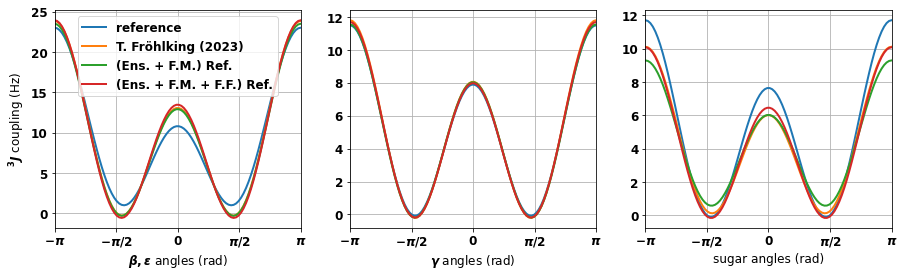

In [79]:
font = {'weight' : 'bold', 'size' : 12}

# plt.rcdefaults()
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 10

fig, axs = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(4)
fig.set_figwidth(15)

compute_deltaV = lambda fm_coeffs, angles, s: fm_coeffs['A_' + s]*np.cos(angles)**2 + fm_coeffs['B_' + s]*np.cos(angles) + fm_coeffs['C_' + s]*np.ones(len(angles))

# plt.suptitle(r'Refinement of Karplus equations $\alpha=%.2f,\beta=%.2f,\gamma=%.2f$' % (opt_alpha, opt_beta, opt_gamma))

angles = np.linspace(-np.pi, np.pi, 100)
titles = [r'$\beta,\epsilon$', r'$\gamma$', 'sugar']

for i,s in enumerate(['beta', 'gamma', 'sugar']):

    deltaV = {}

    deltaV = compute_deltaV(fm_coeffs['original'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='reference')

    deltaV = compute_deltaV(fm_coeffs['Thorben'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='T. Fröhlking (2023)')

    deltaV = compute_deltaV(fm_coeffs['mine'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='(Ens. + F.M.) Ref.')

    deltaV = compute_deltaV(fm_coeffs['mine 2'], angles, s)
    axs[i].plot(angles, deltaV, '-', label='(Ens. + F.M. + F.F.) Ref.')

    # deltaV = compute_deltaV(fm_coeffs['100 optimal'], angles, s) #  ['mean'], angles, s)
    # axs[i].plot(angles, deltaV, '-', label='this study 2') #   (average)')

    # for j in range(n_seeds):
    #     deltaV = compute_deltaV(fm_coeffs['mine'][j], angles, s)
    #     axs[i].plot(angles, deltaV, '-', color='tab:red')#, label='av. mine')


    # for k in ['original', 'mini2', 'mine']:
    #     deltaV[k] = fm_coeffs[k]['A_' + s]*np.cos(angles)**2 + fm_coeffs[k]['B_' + s]*np.cos(
    #         angles) + fm_coeffs[k]['C_' + s]*np.ones(len(angles))

    #     axs[i].plot(angles, deltaV[k], '-', label=k)
    
    axs[i].grid()
    axs[i].set_xlabel(titles[i] + ' angles (rad)')
    # axs[i].set_title(titles[i])
    axs[i].set_xlim([-np.pi, np.pi])
    axs[i].set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    axs[i].set_xticklabels([r'$-\pi$', r'$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

axs[0].legend()
axs[0].set_ylabel('$^3J$ coupling (Hz)')

# plt.savefig('../Figures/Karplus_refinement_overall.png')
plt.show()

In [80]:
my_ff_coeffs = df_result.loc['E+FM+FF ref'][['sin alpha', 'cos alpha']].to_dict()

ff_coeffs = {'this study': my_ff_coeffs,
    'FFR': {'sin alpha': 0.91, 'cos alpha': 1.67},
    'ER+FFR': {'sin alpha': 0.51, 'cos alpha': 1.65}}

In [81]:
ff_coeffs

{'this study': {'sin alpha': 0.5840721894788735,
  'cos alpha': -0.7914544075926866},
 'FFR': {'sin alpha': 0.91, 'cos alpha': 1.67},
 'ER+FFR': {'sin alpha': 0.51, 'cos alpha': 1.65}}

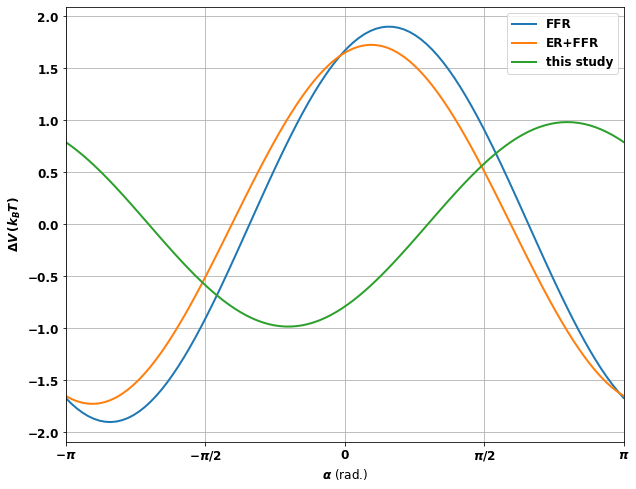

In [82]:
font = {'weight' : 'bold', 'size' : 12}

# plt.rcdefaults()
matplotlib.rc('font', **font)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['lines.markersize'] = 10

angles = np.linspace(-np.pi, np.pi, 100)

plt.figure(figsize=(10, 8))

deltaV = {}

labels = ['FFR', 'ER+FFR', 'this study']

for i, s in enumerate(labels):
    deltaV[s] = ff_coeffs[s]['cos alpha']*np.cos(angles) + ff_coeffs[s]['sin alpha']*np.sin(angles)

    plt.plot(angles, deltaV[s], '-', label=labels[i])

plt.legend()
plt.grid()
# plt.title(r'force-field correction $\alpha=%.2f,\beta=%.2f,\gamma=%.2f$' % (opt_alpha, opt_beta, opt_gamma))

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
plt.xlim([-np.pi, np.pi])
plt.xlabel(r'$\alpha$ (rad.)')
plt.ylabel('$\Delta V \, (k_B T)$')
plt.show()

#### load dihedral angles and new weights

In [19]:
my_angles = {}

for s in infos['global']['system_names']:

    my_angles[s] = []
    length = len(data.sys[s].f.T)//2

    for i in range(length):

        angles = np.arcsin(data.sys[s].f[:, i])
        wh = np.argwhere(data.sys[s].f[:, i + length] < 0)
        angles[wh] = np.pi - angles[wh]
        angles = np.mod(angles, 2*np.pi)

        wh = np.argwhere((angles > np.pi) & (angles < 2*np.pi))
        angles[wh] = angles[wh] - 2*np.pi

        my_angles[s].append(angles)

In [20]:
weights_new = {}
weights_new['E+FM ref'] = {}
weights_new['E+FM+FF ref ff'] = {}
weights_new['E+FM+FF ref'] = {}

for s in infos['global']['system_names']:
    weights_new['E+FM ref'][s] = np.load(path + '/' + my_str + my_list[1] + '/' + '/weights_new_%s.npy' % s)
    weights_new['E+FM+FF ref ff'][s] = np.load(path + '/' + my_str + my_list[1] + '/' + '/weights_ff_%s.npy' % s)
    weights_new['E+FM+FF ref'][s] = np.load(path + '/' + my_str + my_list[1] + '/' + '/weights_new_%s.npy' % s)

In [21]:
print(my_angles[s][0].shape, weights_new['E+FM ref'][s].shape)

(101200,) (101200,)


In [22]:
from MDRefine import compute_new_weights

In [23]:
for s2 in ['FFR', 'ER+FFR']:

    pars = np.array(list(ff_coeffs[s2].values()))
    
    weights_new[s2] = {}
    
    for s in infos['global']['system_names']:
        correction = data.sys[s].ff_correction(pars, data.sys[s].f)/data.sys[s].temperature
        weights_new[s2][s] = compute_new_weights(data.sys[s].weights, correction)[0]

#### hypersearch

In [96]:
my_list

Index(['2024_10_01_13_36_53_483051', '2024_10_03_12_35_46_920644',
       '2024_10_04_08_24_52_792385', '2024_10_02_14_27_55_647283',
       '2024_10_02_16_02_50_308496', '2024_10_02_19_38_45_268929'],
      dtype='object')

In [97]:
dfs_hyper = {}
dfs_hyper[0] = pandas.read_csv(path + '/' + my_str + my_list[0] + '/' + 'hyper_search', index_col=0)

dfs_hyper[0]

,av_chi2,av_gradient alpha,log10_hyperpars alpha,av_gradient gamma,log10_hyperpars gamma
0,1.494645e+06,-83484.150525,0.000000,6864.549112,0.000000
1,3.640039e+03,-7654.440449,0.996637,-1.041580,-0.081949
2,3.150122e+03,-2897.590946,1.097314,-28.726717,-0.081118
3,3.008081e+03,-1689.717108,1.158654,-25.292575,-0.079651
4,2.905336e+03,-756.889430,1.244485,-14.950528,-0.076566
5,2.863234e+03,-463.559900,1.314144,-13.941165,-0.073464
6,2.826691e+03,-248.580847,1.424348,-14.098655,-0.065650
7,2.792318e+03,-167.420569,1.552302,-17.791933,-0.049322
8,2.799691e+03,215.037340,1.823207,-19.598546,0.024903
9,2.784123e+03,-13.669974,1.665665,-19.469618,-0.018261


In [101]:
dfs_hyper[1] = pandas.read_csv(path + '/' + my_str + my_list[1] + '/' + 'hyper_search', index_col=0)

dfs_hyper[1]

,av_chi2,av_gradient alpha,log10_hyperpars alpha,av_gradient beta,log10_hyperpars beta,av_gradient gamma,log10_hyperpars gamma
0,1.492265e+06,-131752.250461,0.000000,4309.731730,0.000000,8201.983928,0.000000
1,6.048931e+03,-1827.753904,0.997536,-2654.318168,-0.032630,363.729927,-0.062100
2,5.961701e+03,-2436.721936,1.012011,-2661.525493,-0.012005,354.180727,-0.064944
3,5.521062e+03,-4236.963742,1.069908,-2647.068794,0.070496,297.189956,-0.076320
4,3.515302e+03,-4529.681650,1.301497,-1997.389598,0.400499,89.559859,-0.121825
5,1.356018e+03,-792.276702,2.227854,522.485446,1.720510,-3.889771,-0.303847
6,1.296206e+03,302.932881,2.408530,-625.556200,1.679429,-1.133588,-0.307227
7,1.256855e+03,-139.193478,2.474971,-88.051435,1.812841,-1.460127,-0.321588
8,1.219645e+03,-221.532270,2.679677,83.958141,2.020229,-0.960379,-0.348075
9,1.235216e+03,-526.791253,3.067895,863.706156,2.368460,-0.435284,-0.392212


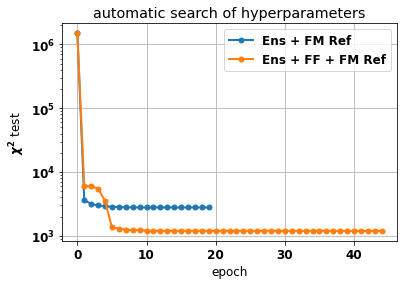

In [103]:
plt.plot(dfs_hyper[0]['av_chi2'], '.-', label='Ens + FM Ref')
plt.plot(dfs_hyper[1]['av_chi2'], '.-', label='Ens + FF + FM Ref')

plt.yscale('log')
plt.grid()
plt.xlabel('epoch')
plt.ylabel(r'$\chi^2$ test')
plt.title('automatic search of hyperparameters')
plt.legend()

# plt.savefig('../../Figures/compare_chi2.pdf', format='pdf', bbox_inches='tight')

#### histograms

- alpha dihedral angles

In [24]:
bins = np.arange(-np.pi, np.pi, 0.05)
my_list = ['original'] + list(weights_new.keys())

my_hists = {}

for s in my_list:
    my_hists[s] = {}
    for s2 in infos['global']['system_names']:
        my_hists[s][s2] = []

for s in infos['global']['system_names']:
    for i in range(len(my_angles[s])):
        my_hists['original'][s].append(np.histogram(my_angles[s][i], bins=bins, density=True))
        for s2 in my_list[1:]:
            my_hists[s2][s].append(np.histogram(my_angles[s][i], bins=bins, density=True, weights=weights_new[s2][s]))


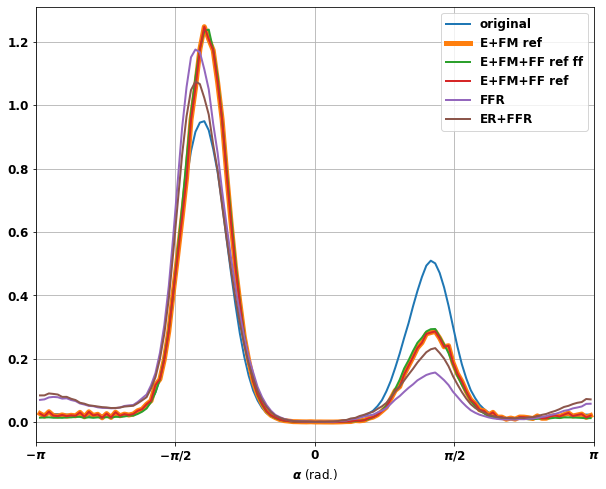

In [41]:
plt.figure(figsize=(10, 8))

tot_hist = {}

for s2 in my_list: tot_hist[s2] = np.zeros(len(my_hists['original']['AAAA'][0][0]))

counter = 0

for s in infos['global']['system_names']:
    for i in range(len(my_hists['original'][s])):
        for s2 in my_list:
            tot_hist[s2] += my_hists[s2][s][i][0]
        counter += 1

# labels = ['original', 'this study', 'this study (with ER)', 'FFR only', 'FFR + ER']

x = my_hists['original'][s][i][1][1:]

# tot_hist['original'] = tot_hist['original']/counter
# plt.fill_between(x, np.zeros(len(x)), tot_hist['original'], alpha=0.4, label='original')

for i, s2 in enumerate(my_list):
    tot_hist[s2] = tot_hist[s2]/counter

    if i == 1: lw = 5
    else: lw = 2

    # plt.plot(my_hists['original'][s][i][1][1:], my_hists[s2]['AAAA'][0][0])
    plt.plot(x, tot_hist[s2], '-', label=s2, linewidth=lw)
    # plt.fill_between(x, np.zeros(len(x)), tot_hist[s2], alpha=0.6)

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
plt.xlim([-np.pi, np.pi])
plt.xlabel(r'$\alpha$ (rad.)')
plt.legend()
plt.grid()

- forward-model dihedral angles

In [69]:
my_hists_fm = {}

for s in my_list:
    my_hists_fm[s] = {}
    for s2 in infos['global']['system_names']:
        my_hists_fm[s][s2] = {}
        for s3 in data.sys[s2].forward_qs.keys():
            my_hists_fm[s][s2][s3] = []

for s in infos['global']['system_names']:
    for s2 in data.sys[s].forward_qs.keys():
        for i in range(data[s].forward_qs[s2].shape[1]):
            my_hists_fm['original'][s][s2].append(np.histogram(data.sys[s].forward_qs[s2][:, i], bins=bins, density=True))
            for s3 in my_list[1:]:
                my_hists_fm[s3][s][s2].append(np.histogram(data.sys[s].forward_qs[s2][:, i], bins=bins, density=True, weights=weights_new[s3][s]))


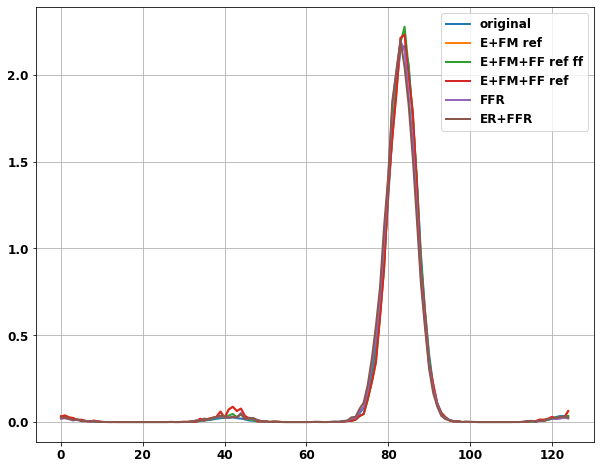

In [78]:
plt.figure(figsize=(10, 8))

for s in my_list:
    plt.plot(my_hists_fm[s]['CAAU']['backbone1_gamma'][3][0], '-', label=s)

plt.legend()
plt.grid()

The current ones look the same, why? Because the only correction you need is on the forward model!

So, the ensemble changes very little: what matters mostly is the forward model!

Is this confirmed by the relative entropy?

No, the relative entropy is even higher, just we are looking only at the alpha dihedral angles and there is no further correction on the ensembles in this direction. What happens when looking at other angles, like the dihedral angles, for instance?

In [20]:
my_cols = ['optimal alpha', 'optimal beta', 'optimal gamma']

print('ER+FMR:\n', df_result.loc['E+FM ref'][[s for s in my_cols if s in df_result.columns]])

print('\n\nfully combined:\n', df_result.loc['E+FM+FF ref'][[s for s in my_cols if s in df_result.columns]])

cols = [s for s in df_result.columns if s.startswith('D_KL_alpha') or s.startswith('reg_ff')]
print('\n', df_result[cols])


ER+FMR:
 optimal alpha     10.7929
optimal beta          NaN
optimal gamma    0.862106
Name: E+FM ref, dtype: object


fully combined:
 optimal alpha       11.101
optimal beta     0.0417573
optimal gamma     0.968467
Name: E+FM+FF ref, dtype: object

              reg_ff_AAAA  reg_ff_CAAU  reg_ff_CCCC  reg_ff_GACC  reg_ff_UUUU  \
E+FM+FF ref     0.418906     0.657361     0.586903     0.312384     0.435219   
E+FM ref             NaN          NaN          NaN          NaN          NaN   

             reg_ff_UCAAUC  D_KL_alpha_AAAA  D_KL_alpha_CAAU  D_KL_alpha_CCCC  \
E+FM+FF ref        1.08491         0.786201         0.645191         0.493777   
E+FM ref               NaN         0.767926         1.398764         0.896253   

             D_KL_alpha_GACC  D_KL_alpha_UUUU  D_KL_alpha_UCAAUC  
E+FM+FF ref         0.301937         0.627644           2.914331  
E+FM ref            0.253224         0.591585           3.668946  


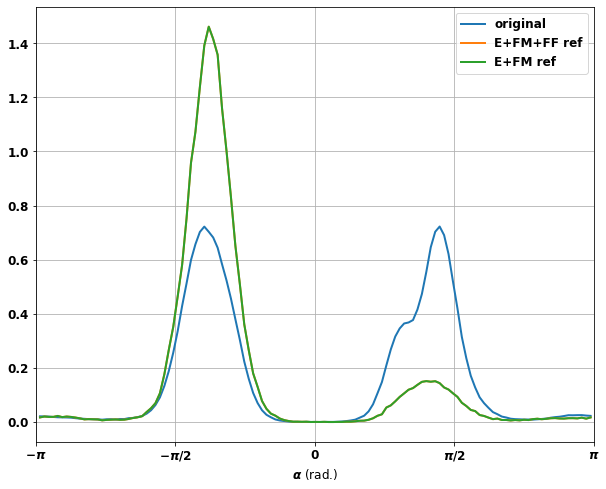

In [55]:
s = 'CAAU'

plt.figure(figsize=(10, 8))

x = my_hists['original'][s][i][1][1:]

for s2 in ['original', 'E+FM+FF ref', 'E+FM ref']:
    hist = np.mean(np.array([my_hists[s2][s][i][0] for i in range(len(my_hists['original'][s]))]), axis=0)
    plt.plot(x, hist, label=s2)

# plt.plot(x, my_hists['original'][s][1][0], label='E+FM+FF ref')
# plt.plot(x, my_hists['E+FM+FF ref'][s][1][0], label='E+FM+FF ref')
# plt.plot(x, my_hists['E+FM ref'][s][1][0], label='E+FM ref')

plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
plt.xlim([-np.pi, np.pi])
plt.xlabel(r'$\alpha$ (rad.)')
plt.legend()
plt.grid()

dict_keys(['E+FM ref', 'E+FM+FF ref ff', 'E+FM+FF ref', 'FFR', 'ER+FFR'])


<Figure size 432x288 with 0 Axes>

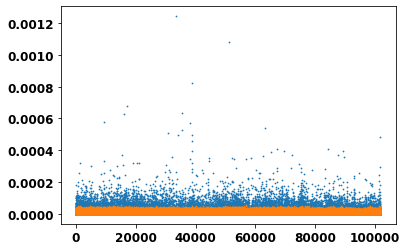

<Figure size 432x288 with 0 Axes>

In [120]:
print(weights_new.keys())

s2 = 'E+FM+FF ref ff'
s = 'AAAA'

plt.plot(weights_new['E+FM+FF ref'][s], '.', markersize=1.5)
plt.plot(weights_new[s2][s], '.', markersize=1.5)

plt.figure()

dict_keys(['backbone1_gamma', 'backbone2_beta_epsilon', 'sugar'])


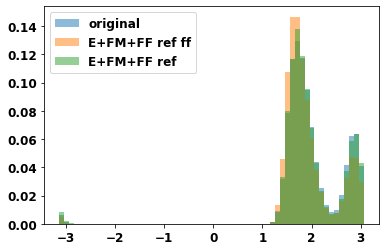

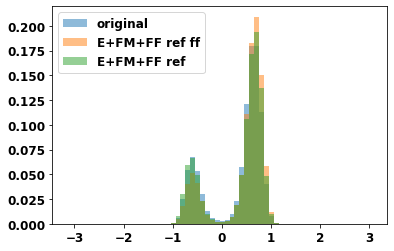

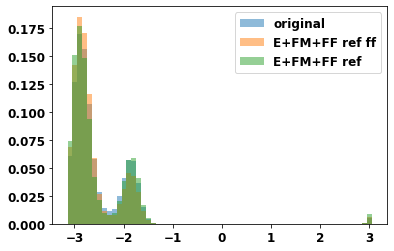

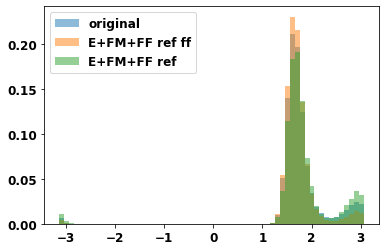

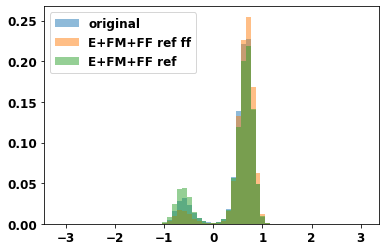

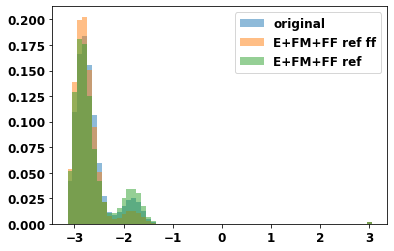

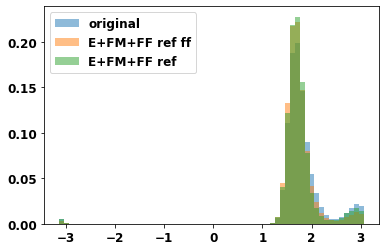

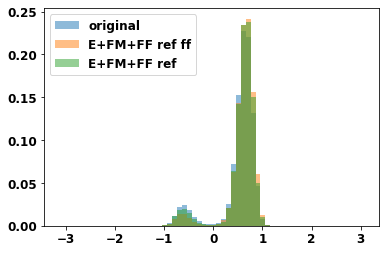

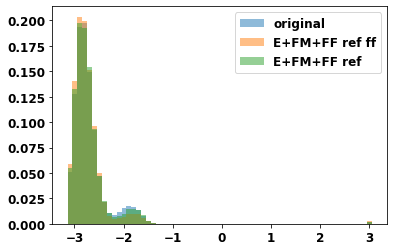

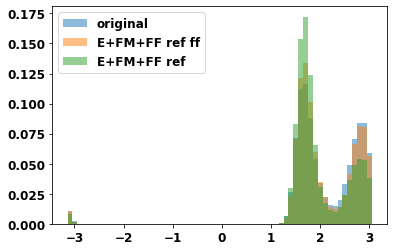

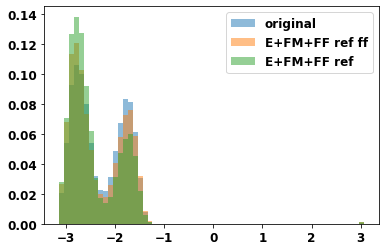

In [121]:
print(data.sys[s].forward_qs.keys())

angles = data.sys[s].forward_qs['sugar']
bins = np.arange(-np.pi, np.pi, 0.1)

for i in range(angles.shape[1]):
    plt.figure()
    plt.hist(angles[:, i], bins, weights=data.sys[s].weights, alpha=0.5, label='original')[2]
    plt.hist(angles[:, i], bins, weights=weights_new['E+FM+FF ref ff'][s], alpha=0.5, label='E+FM+FF ref ff')[2]
    plt.hist(angles[:, i], bins, weights=weights_new['E+FM+FF ref'][s], alpha=0.5, label='E+FM+FF ref')[2]
    plt.legend()

##### ratio for a specific refinement

next, let's focus on a refinement **s2** and a single system **s**:
- plot original and new weights; compute their ratio and plot it;
- compute the Kish size and the relative Kish size;
- plot angle vs. ratio

In [124]:
s2 = 'FFR'
s = 'AAAA'

In [125]:
w0 = data.sys[s].weights
w1 = weights_new['E+FM+FF ref ff'][s]
w2 = weights_new['E+FM+FF ref'][s]

relS = np.sum(w2*np.log(w2/w1))
print(relS)

relS = np.sum(w1*np.log(w1/w0))
print(relS)

relS = np.sum(w2*np.log(w2/w0))
print(relS)

0.786201308227467
0.41890605502764977
1.0623920266189786


In [126]:
s2 = 'E+FM+FF ref ff'

54066.34423105201
1.8810223152019678


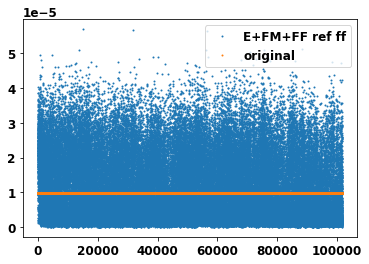

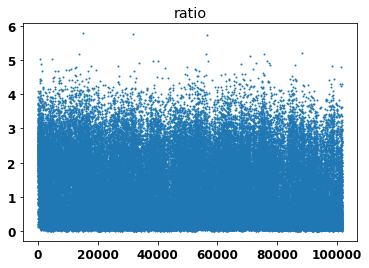

In [127]:
plt.plot(weights_new[s2][s], '.', markersize=2, label=s2)
plt.plot(data.sys[s].weights, '.', markersize=2, label='original')
plt.legend()

plt.figure()
ratio = weights_new[s2][s]/data.sys[s].weights
# ratio = weights_new['E+FM+FF ref'][s]/weights_new['E+FM+FF ref ff'][s]
plt.plot(ratio, '.', markersize=2)
plt.title('ratio')
# plt.yscale('log')

Kish = 1/np.sum(weights_new[s2][s]**2)

print(Kish)
# print(np.exp(-Result.D_KL_alpha[s]))

rel_kish = np.sum(weights_new[s2][s]**2/data.sys[s].weights)
print(rel_kish)

6


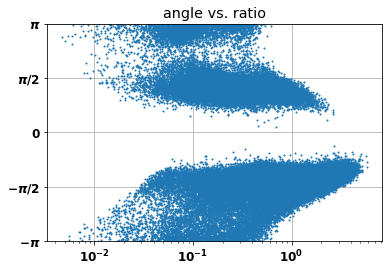

In [128]:
length = len(data.sys[s].f.T)//2
print(length)

i = 0

angles = np.arcsin(data.sys[s].f[:, i])
wh = np.argwhere(data.sys[s].f[:, i + length] < 0)
angles[wh] = np.pi - angles[wh]
angles = np.mod(angles, 2*np.pi)

wh = np.argwhere((angles > np.pi) & (angles < 2*np.pi))
angles[wh] = angles[wh] - 2*np.pi

plt.plot(ratio, angles, '.', markersize=2)
plt.xscale('log')
plt.title('angle vs. ratio')
plt.ylim([-np.pi, np.pi])
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])
plt.grid()

here it's evident that negative angles are favoured by the reweighting w.r.t. positive angles; if instead we look at the dihedral angles used in the forward model, there is not such a correlation

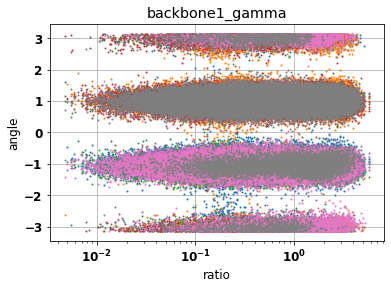

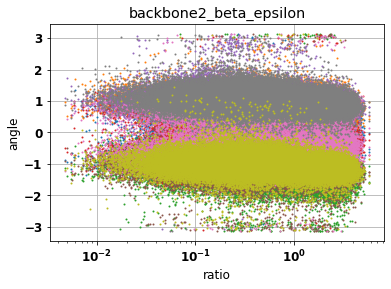

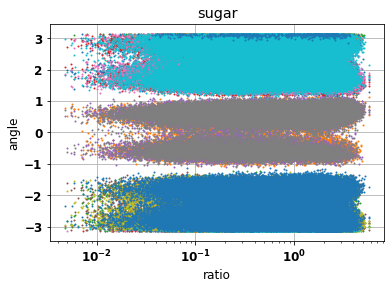

In [129]:
for key in data.sys[s].forward_qs.keys():

    plt.figure()
    plt.title(key)
    
    length = len(data.sys[s].forward_qs[key].T)
    
    for i in range(length):
        angles = data.sys[s].forward_qs[key][:, i]
        plt.plot(ratio, angles, '.', markersize=2)
    
    plt.xscale('log')
    plt.xlabel('ratio')
    plt.ylabel('angle')
    plt.grid()
    plt.show()